<a href="https://colab.research.google.com/github/nklsrmy/CCADMACL_EXERCISES_COM222ML/blob/main/Exercise6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 6

Netflix is the world's largest online streaming service provider, with over 220 million subscribers. It is crucial that they effectively cluster the shows that are hosted on their platform in order to enhance the user experience, thereby preventing subscribers from ending their subscription.

We will be able to understand the shows that are similar to and different from one another by creating clusters, which may be leveraged to offer the consumers personalized show suggestions depending on their preferences.

## Instructions

1. Your task is to group the Netflix shows into certain clusters such that the shows within a cluster are similar to each other and the shows in different clusters are dissimilar to each other. Use Principal Component Analysis and any Clustering Algorithm.

2. After creating the clusters, profile each cluster that you have created.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS
import re
import string
string.punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as shc

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv("https://github.com/robitussin/CCADMACL_EXERCISES/blob/353cd84703a9e313ee7ecf37fb97a067aa81ddbc/netflix.csv?raw=true")

In [3]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


In [5]:
df.duplicated().sum()

0

In [6]:
df.isna().sum()

,0
show_id,0
type,0
title,0
director,2389
cast,718
country,507
date_added,10
release_year,0
rating,7
duration,0


In [7]:
df[['director','cast','country']] = df[['director','cast','country']].fillna(' ')
df.dropna(axis=0, inplace=True)

In [8]:
df.duplicated().sum()

0

In [45]:
df['textual_data'] = df['description'] + df['listed_in'] + df['rating'] + df['cast'] + df['country'] + df['director']

In [46]:
stop_words = stopwords.words('english')

In [43]:
# Feature Engineering
import nltk
df['textual_data'] = df['description'] + df['listed_in'] + df['rating'] + df['cast'] + df['country'] + df['director']

# Download the 'stopwords' dataset
nltk.download('stopwords')
# Download the 'wordnet' dataset
nltk.download('wordnet') # This line is added to download the 'wordnet' dataset

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'\b(\w+)\1+\b', r'\1', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

df['textual_data'] = df['textual_data'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [47]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=10000)
vectorized_data = tfidf.fit_transform(df['textual_data']).toarray()

In [49]:
tfidf = TfidfVectorizer(stop_words='english', lowercase=False, max_features=10000)
tfidf.fit(df['data'])

dictionary = tfidf.vocabulary_.items()

1. Apply dimensionality reduction using Principal Component Analysis
- Use the necessary number of principal components

In [51]:
# put your answer here
pca = PCA(n_components=3700, random_state=42)
pca.fit(vector)

PCA(n_components=3700, random_state=42)

2. Create a scree plot for each principal component

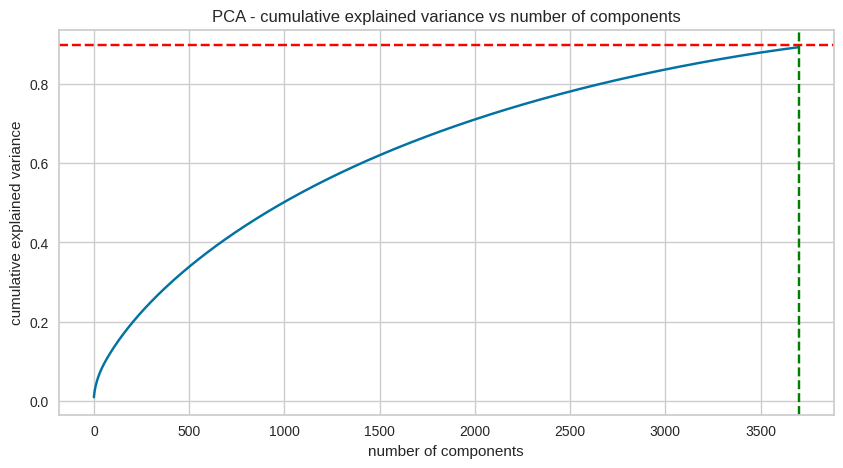

In [66]:
# put your answer here
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA - cumulative explained variance vs number of components')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axhline(y= 0.9, color='red', linestyle='--')
plt.axvline(x= 3700, color='green', linestyle='--')
plt.show()

In [68]:
pca = PCA(n_components=3700, random_state=42)
pca.fit(vector)

PCA(n_components=3700, random_state=42)

In [69]:
# transformed features
X = pca.transform(vector)

# shape of transformed vectors
X.shape

(7770, 3700)

3. Use any clustering algorithm to create clusters

In [72]:
# put your answer here
optimal_clusters = 5  # Assuming 5 based on elbow method analysis
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
# Use X instead of pca_data
df['cluster'] = kmeans.fit_predict(X)

In [74]:
silhouette_avg = silhouette_score(X, df['cluster'])  # Use X instead of pca_data
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.009659120995406606


In [75]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans.fit(X)

KMeans(n_clusters=5, random_state=42)

In [76]:
df['kmeans_cluster'] = kmeans.labels_

4. Profile each cluster that you have generated based on your experiments

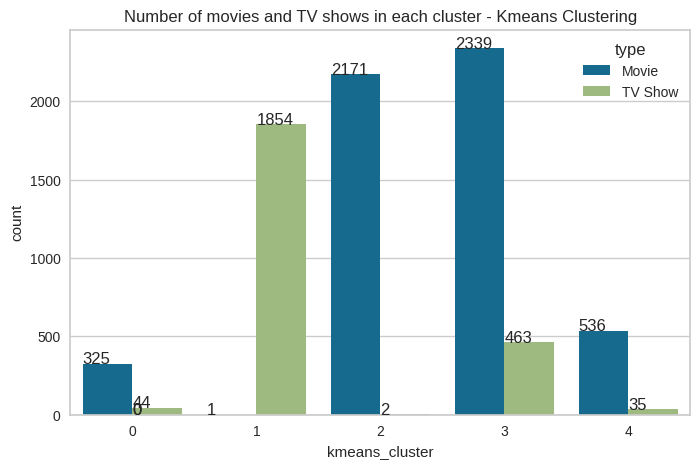

In [32]:
# put your answer here
plt.figure(figsize=(8,5))
graph = sns.countplot(x='kmeans_cluster',data=df, hue='type')
plt.title('Number of movies and TV shows in each cluster - Kmeans Clustering')

for p in graph.patches:
   graph.annotate(format(p.get_height(), '.0f'), (p.get_x(), p.get_height()))

In [78]:
for i in range(optimal_clusters):
    print(f"Cluster {i} Sample Titles:")
    print(df[df['cluster'] == i]['title'].head(100))
    print('\n')

Cluster 0 Sample Titles:
305               Adam Devine: Best Time of Our Lives
307                           ADAM SANDLER 100% FRESH
310                      Adel Karam: Live from Beirut
312     Aditi Mittal: Things They Wouldn't Let Me Say
320                         Afonso Padilha: Classless
                            ...                      
1956       El Especial de Alex Fernández, el Especial
1981                       Ellen DeGeneres: Relatable
2007                          Enissa Amani: Ehrenwort
2021                  Eric Andre: Legalize Everything
2086               Fabrizio Copano: Solo pienso en mi
Name: title, Length: 100, dtype: object


Cluster 1 Sample Titles:
0                                    3%
5                                    46
11                                 1983
12                                 1994
16                               Feb-09
                     ...               
544                     Another Miss Oh
545                   Answer for H

In [79]:
# Sample entries per cluster
df.groupby('kmeans_cluster').sample(10)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,data,kmeans_cluster,textual_data,cluster
7744,s7745,Movie,"Yours Sincerely, Kanan Gill",Neville Shah,Kanan Gill,India,"April 24, 2020",2020,TV-MA,72 min,Stand-Up Comedy,Revisiting life goals set in a letter written ...,revisiting life goal set letter written teen f...,0,Revisiting life goals set in a letter written ...,0
2537,s2538,Movie,Grego Rossello: Disculpe las molestias,Juani Libonatti,Grego Rossello,Argentina,"October 31, 2019",2019,TV-MA,65 min,Stand-Up Comedy,Argentine comedian Grego Rossello takes the st...,argentine comedian grego rossello take stage b...,0,Argentine comedian Grego Rossello takes the st...,0
2945,s2946,Movie,Iliza Shlesinger: Elder Millennial,Steve Paley,Iliza Shlesinger,United States,"July 24, 2018",2018,TV-MA,72 min,Stand-Up Comedy,Newly engaged comic Iliza Shlesinger dives int...,newly engaged comic iliza shlesinger dive unde...,0,Newly engaged comic Iliza Shlesinger dives int...,0
4591,s4592,Movie,"Oh, Hello On Broadway",Michael John Warren,"Nick Kroll, John Mulaney",United States,"June 13, 2017",2017,TV-MA,102 min,Stand-Up Comedy,Two delusional geriatrics reveal curious pasts...,two delusional geriatrics reveal curious past ...,0,Two delusional geriatrics reveal curious pasts...,0
7078,s7079,Movie,Tiffany Haddish: Black Mitzvah,Linda Mendoza,Tiffany Haddish,United States,"December 3, 2019",2019,TV-MA,56 min,Stand-Up Comedy,"On her 40th birthday, Tiffany Haddish drops a ...",th birthday tiffany haddish drop bombastic spe...,0,"On her 40th birthday, Tiffany Haddish drops a ...",0
3145,s3146,Movie,Jen Kirkman: I'm Gonna Die Alone (And I Feel F...,Lance Bangs,Jen Kirkman,United States,"May 22, 2015",2015,TV-MA,78 min,Stand-Up Comedy,"Jen Kirkman delivers some sharp, hilarious tru...",jen kirkman delivers sharp hilarious truth div...,0,"Jen Kirkman delivers some sharp, hilarious tru...",0
7656,s7657,Movie,Wonho Chung: Live in New York,Shaun Mir,Wonho Chung,,"September 11, 2020",2014,TV-14,69 min,Stand-Up Comedy,At the Comic Strip's first Arabic stand-up sho...,comic strip first arabic stand show wonho chun...,0,At the Comic Strip's first Arabic stand-up sho...,0
482,s483,Movie,Amy Schumer Growing,Amy Schumer,Amy Schumer,United States,"March 19, 2019",2019,TV-MA,61 min,Stand-Up Comedy,"Amy Schumer spills on her new marriage, person...",amy schumer spill new marriage personal growth...,0,"Amy Schumer spills on her new marriage, person...",0
7090,s7091,Movie,Tim Allen: ReWires America,,Tim Allen,United States,"December 31, 2018",1991,TV-MA,30 min,Stand-Up Comedy,Standup star Tim Allen storms the stage for a ...,standup star tim allen storm stage set chock f...,0,Standup star Tim Allen storms the stage for a ...,0
3928,s3929,Movie,Marc Maron: End Times Fun,Lynn Shelton,Marc Maron,United States,"March 10, 2020",2020,TV-MA,71 min,Stand-Up Comedy,Marc Maron wades through a swamp of vitamin hu...,marc maron wade swamp vitamin hustler evangeli...,0,Marc Maron wades through a swamp of vitamin hu...,0
